<a href="https://colab.research.google.com/github/Jiiroo19/Grocery-Shopping-App/blob/main/best_for_potassium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-addons
!pip install optuna
!pip install livelossplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.7 MB/s eta 0:00:00


In [ ]:
import os
import sys
from sys import stdout
import logging

import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import clear_output

import scipy.io as sio
from scipy.signal import savgol_filter
import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score , KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv1D, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback,  ModelCheckpoint
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa

## Use liveslossplot for training visualization in real time
from livelossplot import PlotLossesKerasTF

from sklearn.decomposition import PCA

import optuna
import sklearn

In [ ]:
## Check for version of packages
print('Tensorflow ', tf.__version__)
print('Tensorflow add-ons ', tfa.__version__)
print('Optuna ', optuna.__version__)
print('Scikit-Learn ', sklearn.__version__)
print('Pandas', pd.__version__)
print('Numpy ', np.__version__)

# print('tqdm ', tqdm.__version__)
# print('livelossplot ', livelossplot.__version__)

Tensorflow  2.14.0
Tensorflow add-ons  0.23.0
Optuna  3.4.0
Scikit-Learn  1.2.2
Pandas 1.5.3
Numpy  1.23.5


In [ ]:
## Define random seeds ir order to maintain reproducible results through multiple testing phases
def reproducible_comp():
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

reproducible_comp()

In [ ]:
## Function to compute metrics and make prediction plots
def plot_prediction(X_calib, Y_calib, X_valid, Y_valid, X_test, Y_test, Y_calib_pred, Y_valid_pred, Y_test_pred, savefig=False, figname=None):

    ## Compute train error scores
    score_p0 = r2_score(Y_calib, Y_calib_pred)
    mse_p0 = mean_squared_error(Y_calib, Y_calib_pred)
    rmse_p0 = np.sqrt(mse_p0)

    ## Compute valid error scores
    score_p1 = r2_score(Y_valid, Y_valid_pred)
    mse_p1 = mean_squared_error(Y_valid, Y_valid_pred)
    rmse_p1 = np.sqrt(mse_p1)

    ## Compute test error scores
    score_p2 = r2_score(Y_test, Y_test_pred)
    mse_p2 = mean_squared_error(Y_test, Y_test_pred)
    rmse_p2 = np.sqrt(mse_p2)


    print('ERROR METRICS: \t TRAIN \t\t VALID \t\t TEST')
    print('------------------------------------------------------')
    print('R2: \t\t %5.3f \t\t %5.3f \t\t %5.3f'  % (score_p0, score_p1, score_p2 ))
    print('RMSE: \t\t %5.3f \t\t %5.3f \t\t %5.3f' % (rmse_p0, rmse_p1,  rmse_p2))


    ## Plot regression for PLS predicted data
    rangey = max(Y_test) - min(Y_test)
    rangex = max(Y_test_pred) - min(Y_test_pred)

    fig=plt.figure(figsize=(6,6))
    z = np.polyfit(np.ravel(Y_test), np.ravel(Y_test_pred), 1)
    ax = plt.subplot(aspect=1)
    ax.scatter(Y_test,Y_test_pred,c='k',marker='o',s=20, alpha=0.6)
    ax.plot(Y_test, z[1]+z[0]*Y_test, c='blue', linewidth=2,label='linear fit')
    ax.plot(Y_test, Y_test, 'k--', linewidth=1.5, label='y=x')
    plt.ylabel('Predicted NPK Shits')
    plt.xlabel('Measured Shits')
    plt.title('Prediction from CNN')
    plt.legend(loc=4)


    # Print the scores on the plot
    plt.text(min(Y_test_pred)+0.02*rangex, max(Y_test)-0.1*rangey, 'R$^{2}=$ %5.3f'  % score_p2)
    plt.text(min(Y_test_pred)+0.02*rangex, max(Y_test)-0.15*rangey, 'RMSE: %5.3f' % rmse_p2)
    if savefig==True:
        plt.savefig(figname, dpi=96)
        print('Figure saved')
    else:
        plt.show()
    return

In [ ]:
## Source / credit:
#  https://www.kaggle.com/avanwyk/tf2-super-convergence-with-the-1cycle-policy
#  https://www.avanwyk.com/tensorflow-2-super-convergence-with-the-1cycle-policy/

## Functions to implement the LR scheduler using OneCycleScheduler

class CosineAnnealer:

    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0

    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
    """`Callback` that schedules the learning rate on a 1cycle policy as per Leslie Smith's paper(https://arxiv.org/pdf/1803.09820.pdf).
    If the model supports a momentum parameter, it will also be adapted by the schedule.
    The implementation adopts additional improvements as per the fastai library: https://docs.fast.ai/callbacks.one_cycle.html, where
    only two phases are used and the adaptation is done using cosine annealing.
    In phase 1 the LR increases from `lr_max / div_factor` to `lr_max` and momentum decreases from `mom_max` to `mom_min`.
    In the second phase the LR decreases from `lr_max` to `lr_max / (div_factor * 1e4)` and momemtum from `mom_max` to `mom_min`.
    By default the phases are not of equal length, with the phase 1 percentage controlled by the parameter `phase_1_pct`.
    """

    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps

        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0

        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)],
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]

        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)

    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1

        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())

    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None

    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None

    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore

    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]

    def mom_schedule(self):
        return self.phases[self.phase][1]

    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')

class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 1000, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1, figsize=(8,6))
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses, lw=2)

In [ ]:
## Graphics settings
## Setting the font sizes for comming figures
# plt.style.use("default")
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

## uncomment for Latex graphics formating
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.sans-serif": ["Times"]})

# plt.rc('text', usetex=True)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
# Load data
data = pd.read_csv("/content/drive/MyDrive/soil _scans/Training_Set - Copy.csv")
test_data = pd.read_csv("/content/drive/MyDrive/soil _scans/test_set_ideal_OM - Copy.csv")
wavelenght = pd.read_csv("/content/drive/MyDrive/soil _scans/Book1 - Copy.csv")

# #emman
# data = pd.read_csv("/content/drive/MyDrive/soil _scans/TextureResult.csv")
# test_data = pd.read_csv("/content/drive/MyDrive/soil _scans/Book1_Emman.csv")
# wavelenght = pd.read_csv("/content/drive/MyDrive/soil _scans/wave_emman.csv")

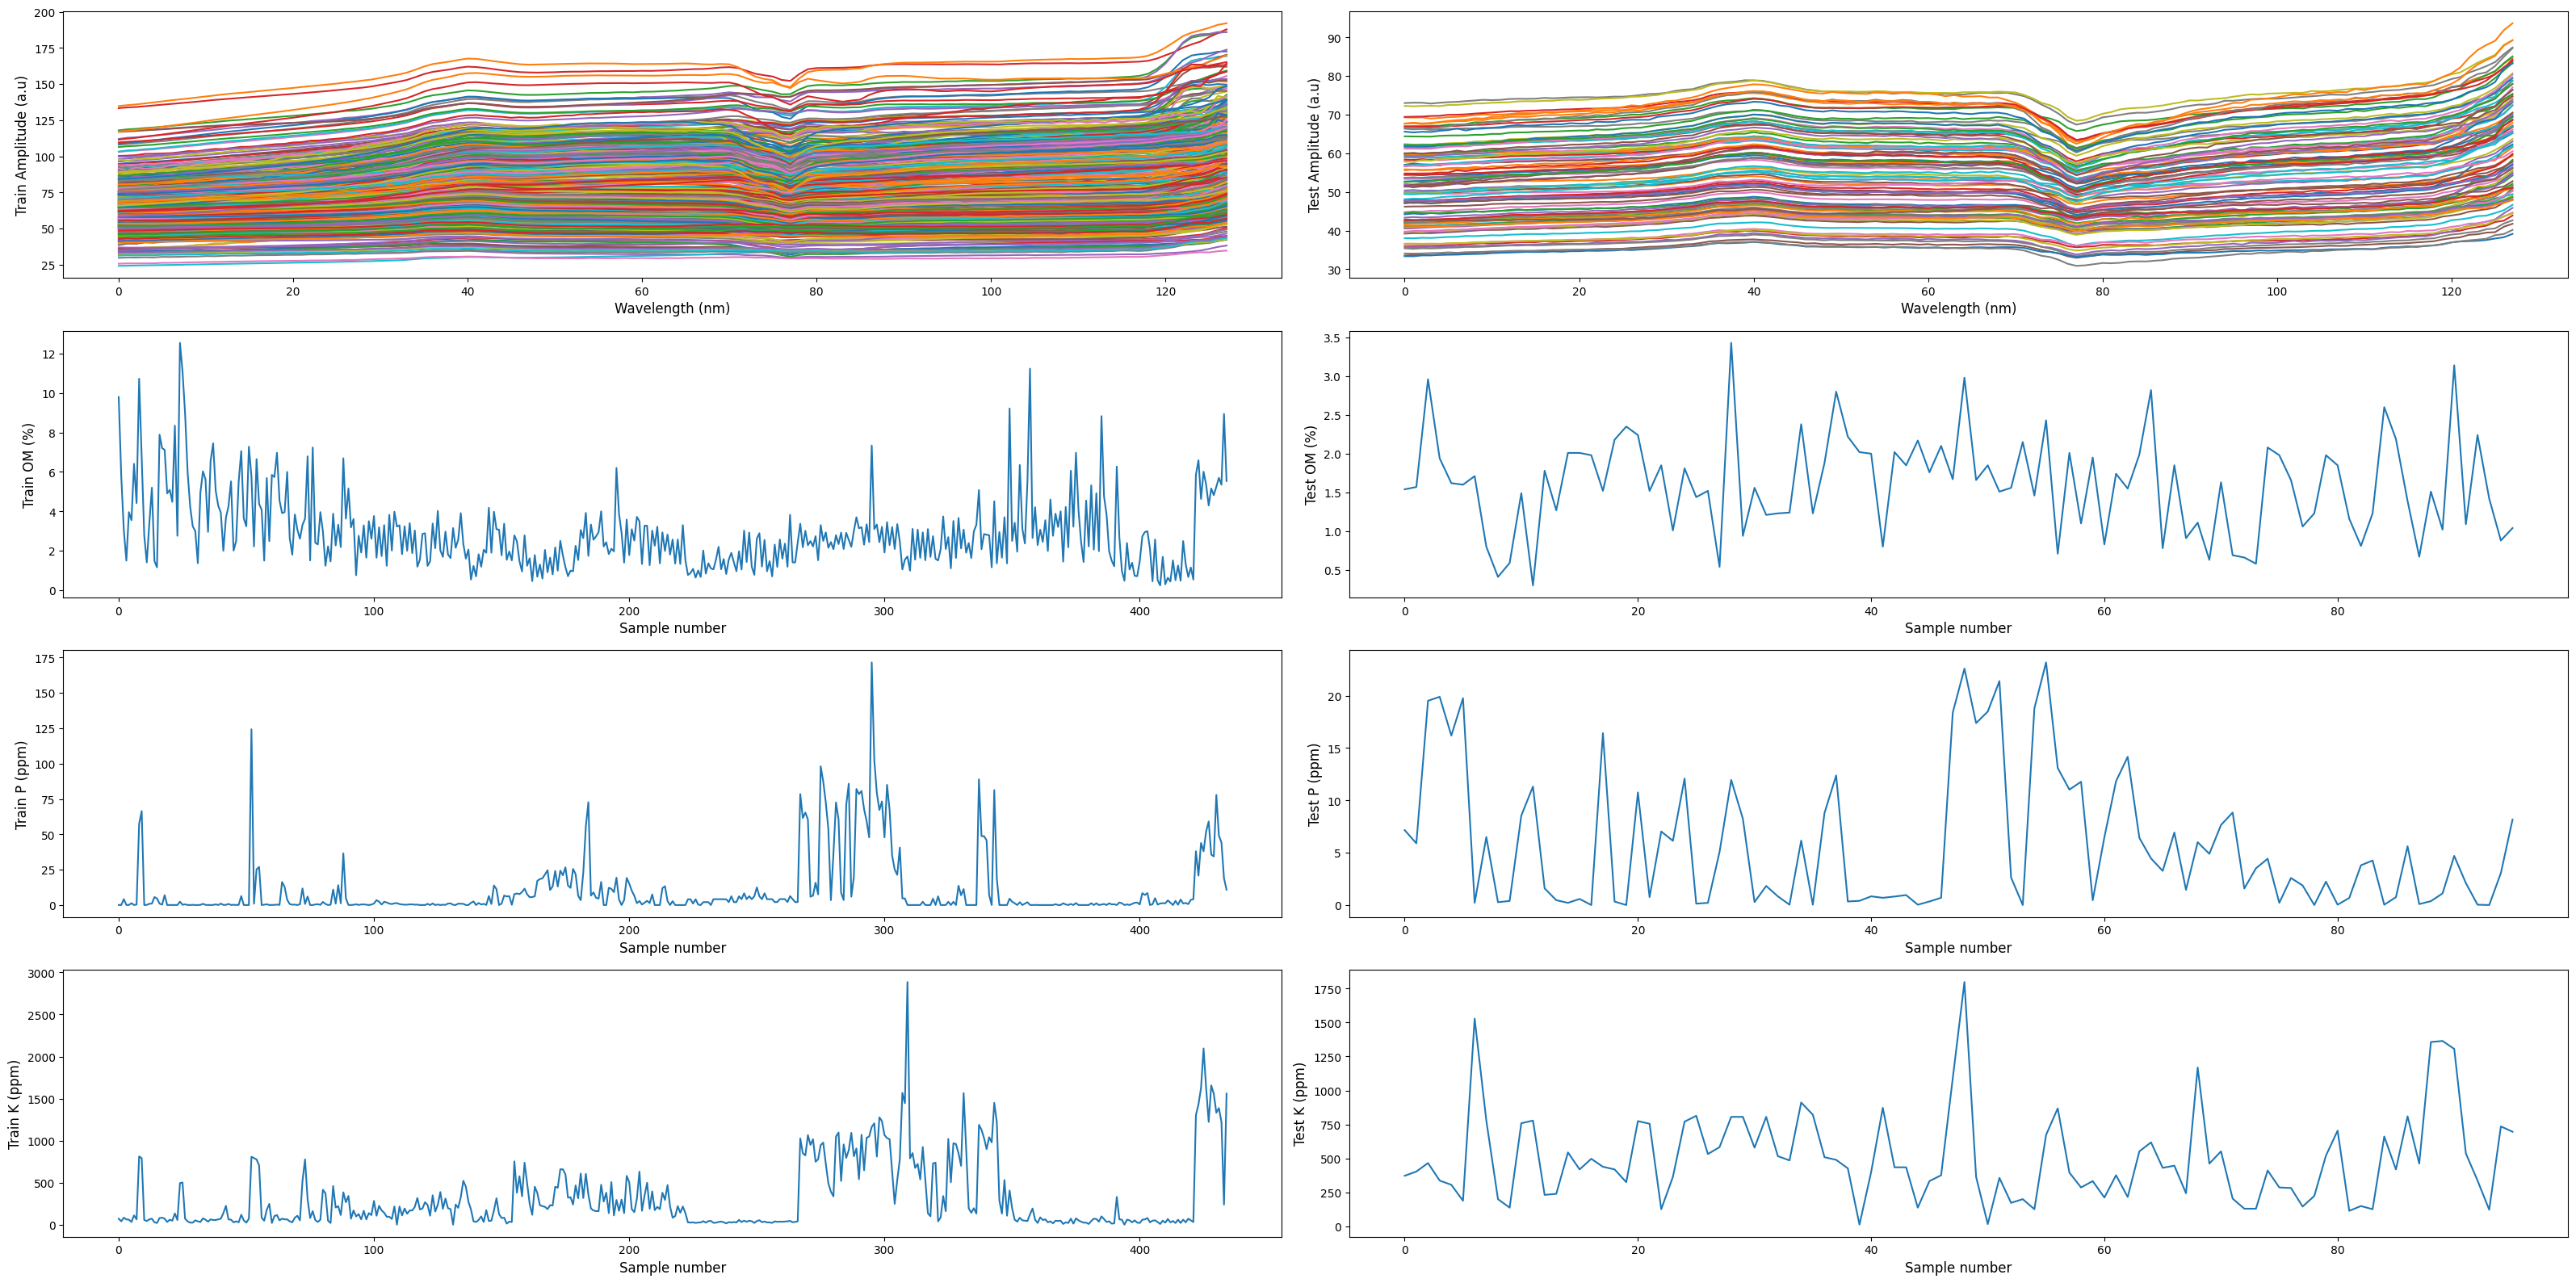

In [ ]:
plt.figure(figsize=(32,16))
plt.subplot(421)
plt.plot(data.iloc[:, 4:].values.astype(np.float32).T)
plt.ylabel('Train Amplitude (a.u)')
plt.xlabel('Wavelength (nm)')
plt.subplot(422)
plt.plot((test_data.iloc[:, 4:].values.astype(np.float32).T))
plt.ylabel('Test Amplitude (a.u)')
plt.xlabel('Wavelength (nm)')
plt.subplot(423)
plt.plot(data.iloc[:, 0].values.astype(np.float32).T)
plt.ylabel('Train OM (%)')
plt.xlabel('Sample number')
plt.subplot(424)
plt.plot(test_data.iloc[:, 0].values.astype(np.float32).T)
plt.ylabel('Test OM (%)')
plt.xlabel('Sample number')
plt.subplot(425)
plt.plot(data.iloc[:, 1].values.astype(np.float32).T)
plt.ylabel('Train P (ppm)')
plt.xlabel('Sample number')
plt.subplot(426)
plt.plot(test_data.iloc[:, 1].values.astype(np.float32).T)
plt.ylabel('Test P (ppm)')
plt.xlabel('Sample number')
plt.subplot(427)
plt.plot(data.iloc[:, 2].values.astype(np.float32).T)
plt.ylabel('Train K (ppm)')
plt.xlabel('Sample number')
plt.subplot(428)
plt.plot(test_data.iloc[:, 2].values.astype(np.float32).T)
plt.ylabel('Test K (ppm)')
plt.xlabel('Sample number')
plt.tight_layout()
plt.show()

In [ ]:
## Spectra (x) and target variable (Y)

x_train = data.iloc[:, 4:].values.astype(np.float32)
x_test = test_data.iloc[:, 4:].values.astype(np.float32)
y_train = data.iloc[:, :3].values.astype(np.float32)
y_test = test_data.iloc[:, :3].values.astype(np.float32)
wavelenghts = wavelenght.iloc[:, :].values


## Spliting the full train set into calib and tuning subsets. It is important to set the 'random_state'
## parameter to a fixed value in order to guarentee that each time you run the experiment, the data is
## split the same way
x_cal, x_tuning, y_cal, y_tuning = train_test_split(x_train, y_train, test_size=0.33, shuffle=True, random_state=42)

## The wavelenghts for the XX axis when we plot the spectra
x_scale=wavelenghts.astype(np.float32).reshape(-1,1)

## Check for dimensions
print('Data set dimensions ----------------------------')
print('Full Train set dims X Y = {}\t{}'.format(x_train.shape, y_train.shape))
print('Calibration set dims X Y = {}\t{}'.format(x_cal.shape, y_cal.shape))
print('Tuning set dims X Y = {}\t{}'.format(x_tuning.shape, y_tuning.shape))
print('Test set dims X Y = {}\t{}'.format(x_test.shape, y_test.shape))
print('wavelengths number = {}'.format(np.shape(x_scale)))

Data set dimensions ----------------------------
Full Train set dims X Y = (435, 128)	(435, 3)
Calibration set dims X Y = (291, 128)	(291, 3)
Tuning set dims X Y = (144, 128)	(144, 3)
Test set dims X Y = (96, 128)	(96, 3)
wavelengths number = (128, 1)


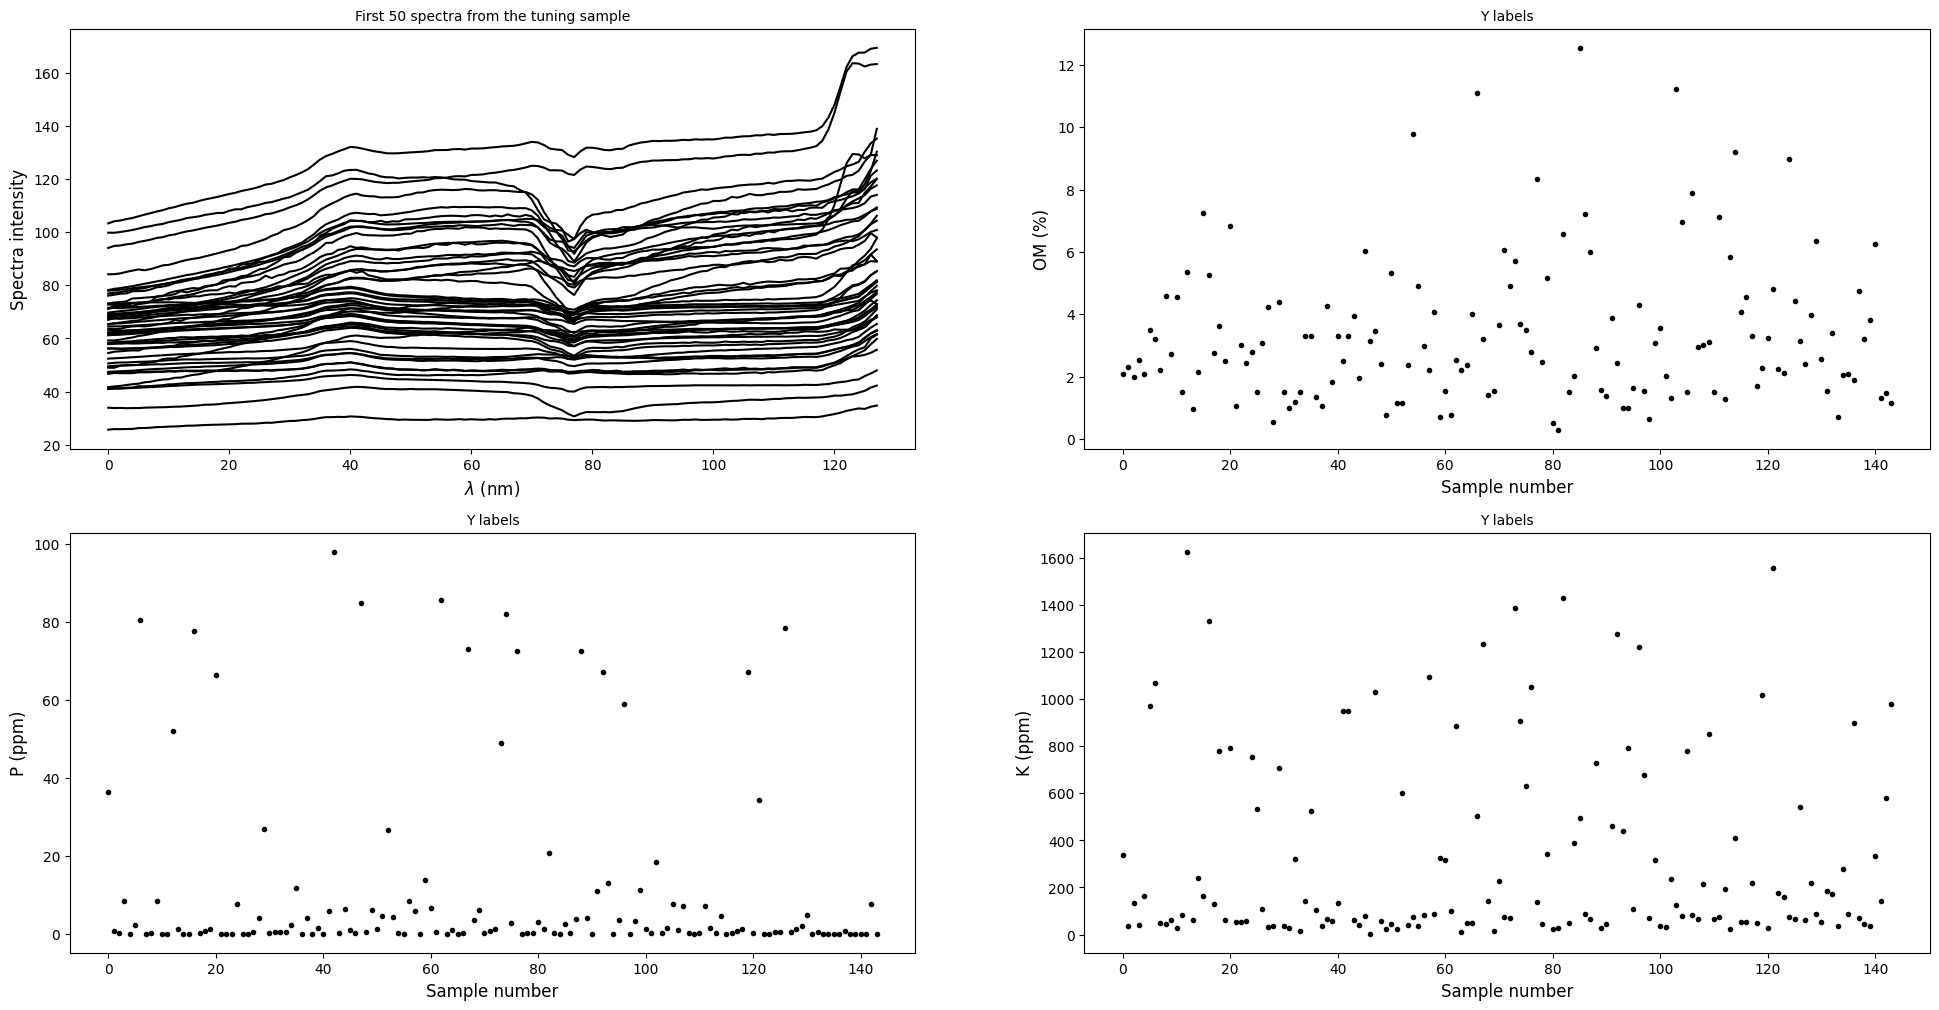

In [ ]:
## Visual data sanity checking for the test set
plt.figure(figsize=(24,12))
plt.subplot(2,2,1)
plt.plot(x_tuning[:50,:].T,'k')
plt.title('First 50 spectra from the tuning sample')
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel('Spectra intensity')
plt.subplot(2,2,2)
plt.title('Y labels')
plt.plot(y_tuning[:,0],'k.')
plt.xlabel('Sample number')
plt.ylabel('OM (%)')
plt.subplot(2,2,3)
plt.title('Y labels')
plt.plot(y_tuning[:,1],'k.')
plt.xlabel('Sample number')
plt.ylabel('P (ppm)')
plt.subplot(2,2,4)
plt.title('Y labels')
plt.plot(y_tuning[:,2],'k.')
plt.xlabel('Sample number')
plt.ylabel('K (ppm)')
plt.show()

In [ ]:
## Since the test set is unknown (we are not suppose to have access to it during the
## optimization of the model) the scalling process should take this into account. We
## have to define a scaler based only on the train data, and apply it to the test data.

def standardize_column(X_train, X_calib, X_tuning, X_test, y_train):
    # We train the scaler on the full train set and apply it to the other datasets
    scaler = MinMaxScaler().fit(X_train)
    ## for columns we fit the scaler to the train set and apply it to the test set

    X_calib_scaled = scaler.transform(X_calib)
    X_tuning_scaled = scaler.transform(X_tuning)
    X_test_scaled = scaler.transform(X_test)

    # pca = PCA()

    # pca.fit(X_train)
    # X_calib_scaled = pca.transform(X_calib)
    # X_tuning_scaled = pca.transform(X_tuning)
    # X_test_scaled = pca.transform(X_test)

    print(X_train.shape)
    print(X_calib_scaled.shape)
    print(X_tuning_scaled.shape)
    print(X_test_scaled.shape)

    return [X_calib_scaled, X_tuning_scaled, X_test_scaled]

In [ ]:
## Standardize on columns
x_cal_scaled_col, x_tuning_scaled_col, x_test_scaled_col = standardize_column(x_train, x_cal, x_tuning, x_test, y_train)

(435, 128)
(291, 128)
(144, 128)
(96, 128)


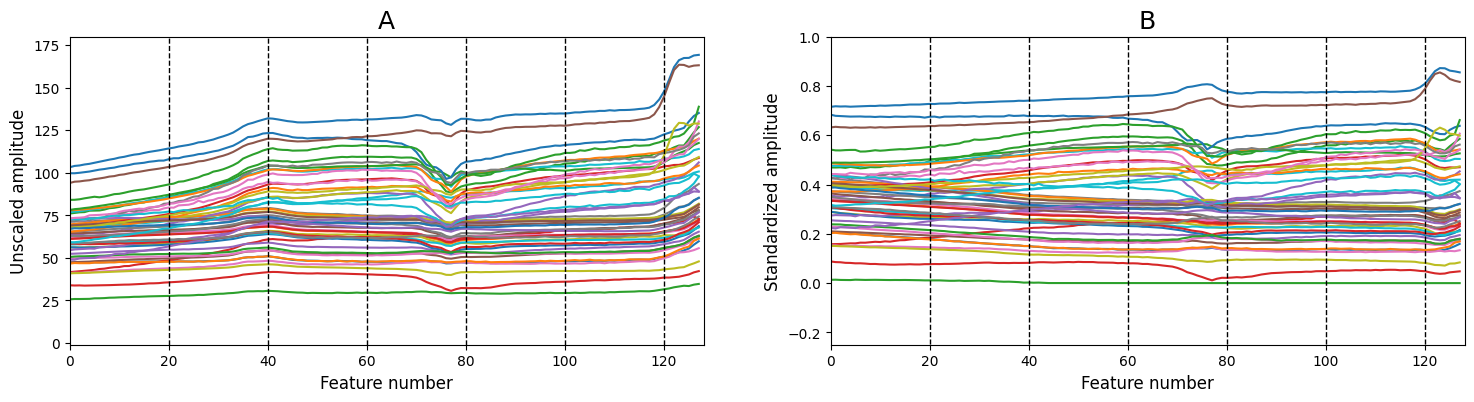

In [ ]:
plt.figure(figsize=(18,4))
## left panel
plt.subplot(121)
plt.title('A', fontsize=18)
plt.plot(x_tuning[:50,:].T)
plt.ylabel('Unscaled amplitude')
plt.xlabel('Feature number')
## vertical dashed lines separating the types of preprocessings that were concatenated
plt.vlines(np.arange(20,128,20), ymin=-1.1, ymax=180, color='k',ls='--',lw=1)
plt.xlim(0,128)
plt.ylim(-1,180)

## right panel
plt.subplot(122)
plt.title('B', fontsize=18)
plt.plot(x_tuning_scaled_col[:50].T)
plt.ylabel('Standardized amplitude')
plt.xlabel('Feature number')
plt.vlines(np.arange(20,128,20), ymin=-7.6, ymax=5.6, color='k',ls='--',lw=1)
plt.xlim(0,128)
plt.ylim(-0.25,1)

plt.show()

In [ ]:
## Make sure computations are reproducible
reproducible_comp()

## This function initializes the model as a function of filter size and L2. regularization strength
def init_model(filter_size, reg_beta):
    ## define the input layer dimensions
    INPUT_DIMS = np.shape(x_cal)[1]
    print(INPUT_DIMS)
    ## conv layer dimensions
    CONV1D_DIMS = INPUT_DIMS
    ## number of kernels (a.k.a. filters)
    K_NUMBER = 1
    ## kernel width
    K_WIDTH = filter_size
    ## kernel stride
    K_STRIDE = 1
    ## Number of neurons on first FC layer
    FC1_DIMS = 256
    ## Number of neurons on second FC layer
    FC2_DIMS = 64
    ## Number of neurons on third FC layer
    FC3_DIMS = 16
    ## Number of neurons on final FC layer
    OUT_DIMS = 3

    ## L2 regularizer parameter
    beta= reg_beta/2.

    ## For the sake of simplicity we do the weights initialization for multiple layers here
    ## Setting he_normal(seed = cte) ensures that everytime the CNN is initialized, it has the same weights configuration.
    ## This is important for reproducibility but can be detrimental for robustness.
    K_INIT = tf.keras.initializers.he_normal(seed=123)

    ## Weights L2 regularization
    K_REG = tf.keras.regularizers.l2(beta)

    ## The CNN is implemented as a sequence of layers using keras.Sequential()
    model_cnn = keras.Sequential([  keras.layers.Reshape((INPUT_DIMS, 1),input_shape=(INPUT_DIMS,)), \
                                #original Conv1D layer
                                keras.layers.Conv1D(filters=K_NUMBER, \
                                                    kernel_size=K_WIDTH, \
                                                    strides=K_STRIDE, \
                                                    padding='same', \
                                                    kernel_initializer=K_INIT,\
                                                    kernel_regularizer=K_REG,\
                                                    activation='elu',\
                                                    input_shape=(CONV1D_DIMS,1)), \

                                # best for P
                                # keras.layers.Conv1D(filters=14, \
                                #                     kernel_size=K_WIDTH, \
                                #                     strides=K_STRIDE, \
                                #                     padding='same', \
                                #                     kernel_initializer=K_INIT,\
                                #                     kernel_regularizer=K_REG,\
                                #                     activation='elu',\
                                #                     input_shape=(CONV1D_DIMS,1)), \
                                # tf.keras.layers.BatchNormalization(), \
                                # keras.layers.Conv1D(filters=14, \
                                #                     kernel_size=K_WIDTH, \
                                #                     strides=K_STRIDE, \
                                #                     padding='same', \
                                #                     kernel_initializer=K_INIT,\
                                #                     kernel_regularizer=K_REG,\
                                #                     activation='elu',\
                                #                     input_shape=(CONV1D_DIMS,1)), \
                                # tf.keras.layers.BatchNormalization(), \

                                # keras.layers.Conv1D(filters=30, \
                                #                     kernel_size=K_WIDTH, \
                                #                     strides=K_STRIDE, \
                                #                     padding='same', \
                                #                     kernel_initializer=K_INIT,\
                                #                     kernel_regularizer=K_REG,\
                                #                     activation='elu',\
                                #                     input_shape=(CONV1D_DIMS,1)), \
                                # keras.layers.Conv1D(filters=30, \
                                #                     kernel_size=K_WIDTH, \
                                #                     strides=K_STRIDE, \
                                #                     padding='same', \
                                #                     kernel_initializer=K_INIT,\
                                #                     kernel_regularizer=K_REG,\
                                #                     activation='elu',\
                                #                     input_shape=(CONV1D_DIMS,1)), \


                                # tf.keras.layers.BatchNormalization(), \

                                keras.layers.Flatten(),
                                # tf.keras.layers.Dropout(.5),


                                keras.layers.Dense(FC1_DIMS, \
                                                   kernel_initializer=K_INIT, \
                                                   kernel_regularizer=K_REG, \
                                                   activation='elu'),

                                keras.layers.Dense(FC2_DIMS, \
                                                   kernel_initializer=K_INIT,\
                                                   kernel_regularizer=K_REG,\
                                                   activation='elu'),

                                # FC3_DIMS
                                keras.layers.Dense(FC3_DIMS , \
                                                   kernel_initializer=K_INIT,\
                                                   kernel_regularizer=K_REG,\
                                                   activation='elu'),


                                keras.layers.Dense(OUT_DIMS, kernel_initializer=K_INIT, \
                                                   kernel_regularizer=K_REG,\
                                                   activation='linear'),
                              ])

    return(model_cnn)

128
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 128, 1)            6         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 3)              

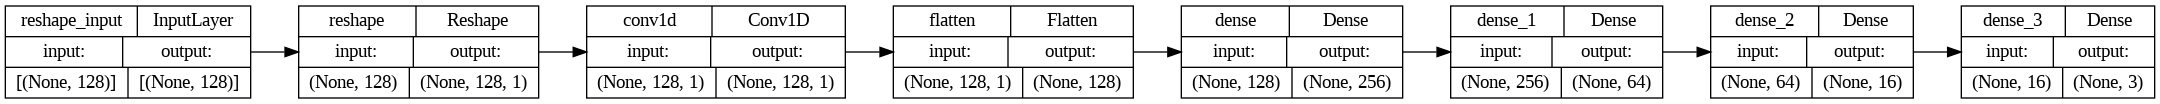

In [ ]:
## Initialize a new CNN with a filter size of 5 points and L2 reg. = 0.0006 (weak regularization)
model_cnn = init_model(5, 0.0006)

## Print the summary of the model
print(model_cnn.summary())

## Plot the architecture of the CNN
## The plot_model() from Keras requires that graphviz and pydot are installed in your system.
## If you dont't have these libraries installed, skip this cell for now and browse for the image "base_cnn_regression.png" in the repository to see the result
plot_model(model_cnn,  to_file='base_cnn_regression.png', show_shapes=True, show_layer_names=True, \
           rankdir='LR', expand_nested=False, dpi=96)

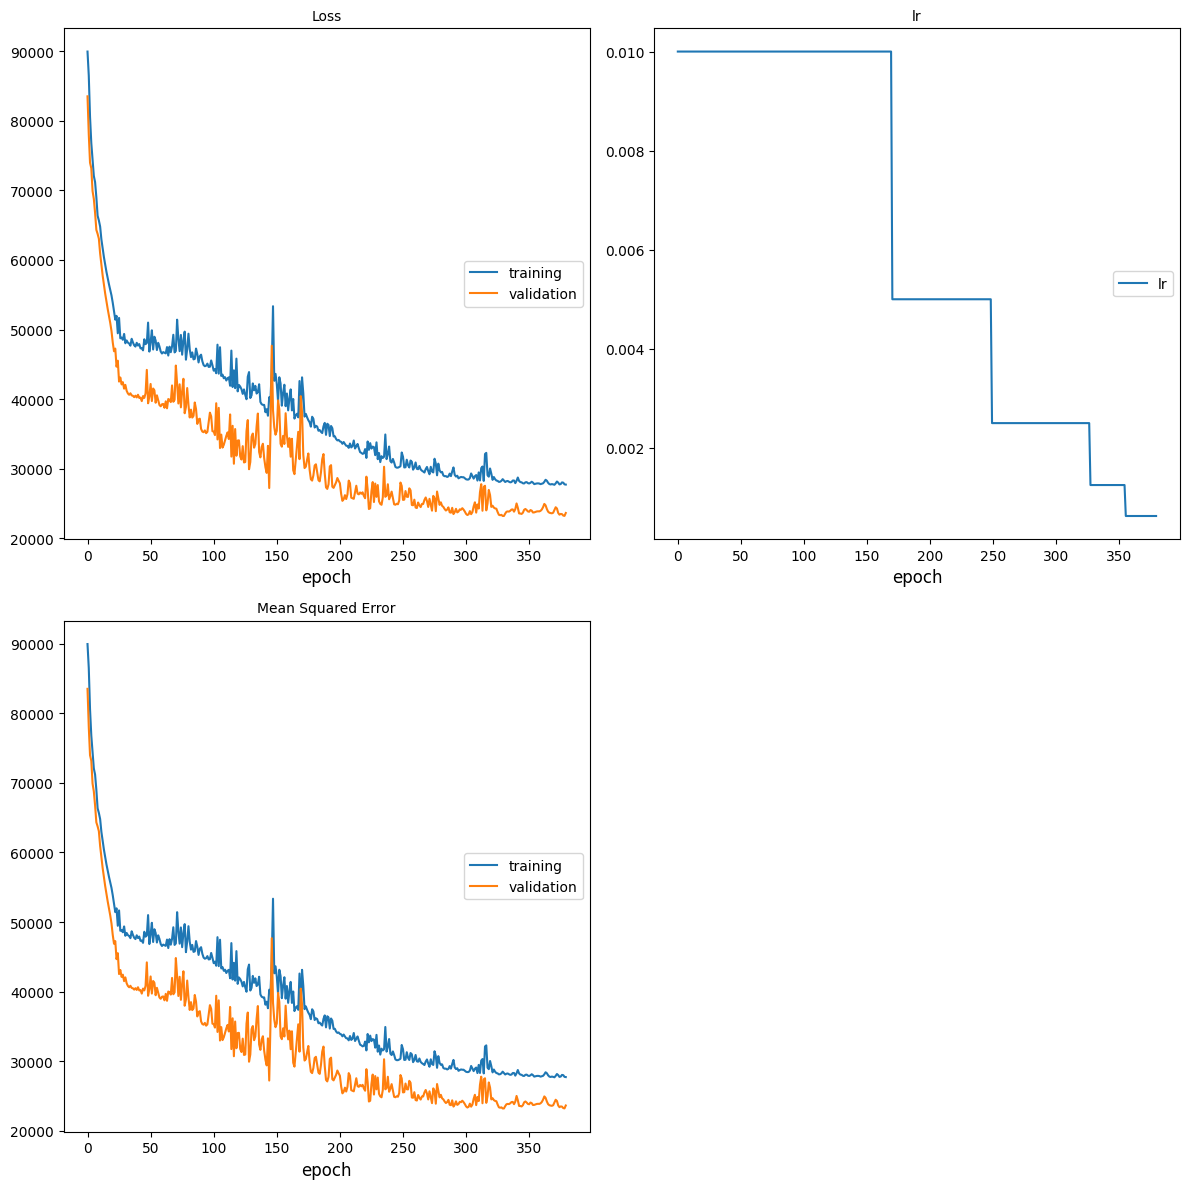

Loss
	training         	 (min: 27689.006, max: 89938.156, cur: 27719.365)
	validation       	 (min: 23204.281, max: 83503.680, cur: 23635.584)
lr
	lr               	 (min:    0.001, max:    0.010, cur:    0.001)
Mean Squared Error
	training         	 (min: 27687.736, max: 89937.961, cur: 27718.094)
	validation       	 (min: 23203.021, max: 83503.469, cur: 23634.312)
2/2 [==============================] - 2s 2s/step - loss: 27719.3652 - mse: 27718.0938 - val_loss: 23635.5840 - val_mse: 23634.3125 - lr: 6.2500e-04


In [ ]:
## Run this base model once to see if its training correctly
## This can be viewed as a baseline that hyperparameter optimization should improve

tf.keras.backend.clear_session()

########### DEFINE HYPERPARAMETERS AND INSTANTIATE THE MODEL #####################
## Define the batch size (number of sample to train for each pass into the CNN)
BATCH = 256
## Define the filter size
FILTER_SIZE = 5
## Define the L2 reg.
L2_BETA = 0.0006

## initialize the model
model_cnn=init_model(FILTER_SIZE, L2_BETA)


########### COMPILE MODEL WITH ADAM OPTIMIZER #####################################

## Heuristic that sets the learning rate
LR=0.01*BATCH/256.
print('Adam learning rate = {}'.format(LR))

## Define the model name for saving purposes
MODEL_NAME = 'base_regression_model.h5'

## Compile the model defining the optimizer, the loss function and the metrics to track during training
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='mse', metrics=['mse'])


########### DEFINE USEFUL CALLBACK FUNCTIONS #####################################

## The following are several callbacks that can be used during training to improve its efficiency and decrease overfit
## 1) Stop the training if it does not improve
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=50, mode='auto', restore_best_weights=True)

## 2) Reduce learning rate dynamically
rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=0)

## 3) Save the best weights into file
checkpointer = ModelCheckpoint(filepath=MODEL_NAME, verbose=1, save_best_only=True)

## 4) Visualize tracked metrics in real time during training
plot_losses = PlotLossesKerasTF()

########### TRAIN THE MODEL #####################################################
## Train the model for 450 epochs on the x_cal data while monitoring the models performance on the x_tuning data.
## The data in the tuning set is not used for actual training. It is only used to measure model performance.
h1 = model_cnn.fit(x_cal_scaled_col, y_cal, batch_size=BATCH, epochs=450, \
      validation_data=(x_tuning_scaled_col, y_tuning),  \
      callbacks=[checkpointer, rdlr, early_stop, plot_losses],verbose=1)

## Clear the session. This is important to ensure that on the next training session, the weights are properly initialized.
## On the other hand if one need to continue a training session for longer, this can just be commented.
tf.keras.backend.clear_session()

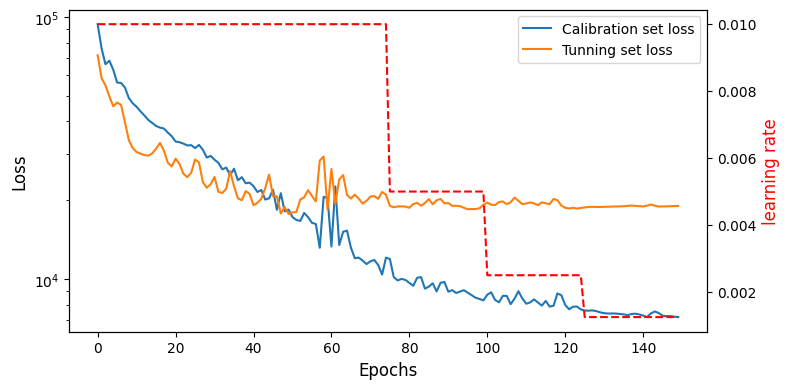

In [ ]:
## If you used Livelossplot, you can skip this. Otherwise we can take a look at the training process by plotting the
## models history.
plt.figure(figsize=(8,4))
plt.plot(h1.history['loss'], label='Calibration set loss')
plt.plot(h1.history['val_loss'], label='Tunning set loss')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
# plt.ylim(0.5,1)
plt.legend()
## In case you used ReduceLROnPlateau() you can plot the lr as well
ax2 = plt.gca().twinx()
ax2.plot(h1.history['lr'], color='r', ls='--')
ax2.set_ylabel('learning rate',color='r')
plt.tight_layout()
plt.show()
# plt.savefig('train_tun_loss.png', dpi=96)

3/3 [==============================] - 0s 6ms/step
ERROR METRICS: 	 TRAIN 		 VALID 		 TEST
------------------------------------------------------
R2: 		 0.497 		 0.559 		 -0.244
RMSE: 		 290.758 		 263.137 		 373.447


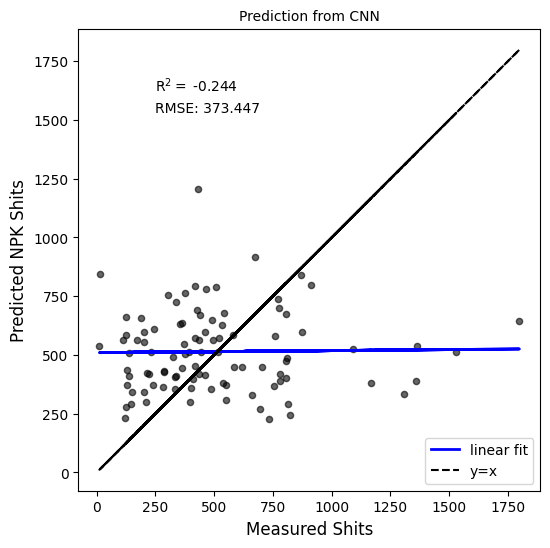

In [ ]:
## Initialize a new model if needed
# model_cnn=init_model(5, 0.0003)

## load pre-computed model weights into model_cnn
model_cnn.load_weights("base_regression_model.h5")

## Compute metrics for CAL, TUNING and TEST sets
y_cal_pred1 = model_cnn.predict(x_cal_scaled_col)
y_tuning_pred1 = model_cnn.predict(x_tuning_scaled_col)
y_test_pred1  = model_cnn.predict(x_test_scaled_col)

# 0 = OM, 1 = P, 2 = K
what_plot = 2

## Plot the prediction. For this case the TRAIN column on the output corresponds to the tuning set
plot_prediction(x_cal_scaled_col, y_cal[:, what_plot], x_tuning_scaled_col, y_tuning[:, what_plot], x_test_scaled_col, y_test[:, what_plot], \
                y_cal_pred1[:, what_plot], y_tuning_pred1[:, what_plot], y_test_pred1[:, what_plot], savefig=False, figname='prediction_base_model.png')